# Ćwiczenie 6
*Tomasz Żebrowski*

### Implementacja

Celem zadania była implementacja algorytmu Q-Learning oraz jej przetestowanie na zadaniu *Taxi*. Realizacja algorytmu zawarta jest w pliku `qlearning.py`. Jej głównym elementem jest funkcja `q_learning`, która przyjmuje następujące parametry:
- `env` - środowisko działania agenta
- `t_max` - limit czasu zadania
- `gamma` - współczynnik dyskontowania
- `beta` - współczynnik szybkości uczenia
- `epochs` - liczba epok
- `action_choose_func` - funkcja służąca do wyboru akcji w danym stanie.
Zaimplementowana została funkcja realizująca wybór akcji zgodnie ze strategią ϵ-zachłanną z możliwością wyboru parametru ϵ.

### Doświadczenia

W pierwszej kolejności konieczne jest zdefiniowanie zadania, na którym działał będzie algorytm. W tym przypadku zadanie jest już wykonane - omawiany problem dostępny jest w pakiecie `gym`. Poniższy kod wczytuje zadanie.

In [1]:
import gym
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np
%matplotlib inline

env = gym.make("Taxi-v3", render_mode="ansi")


Dla utworzonego środowiska tworzymy strategię optymalną wykorzystując zaimplementowany algorytm. Parametry są dobrane bardzo zgrubnie i raczej nie dają gwarancji idealnego działania

In [2]:
from qlearning import q_learning, e_greedy_strategy

Q = q_learning(env, 1000, 0.9, 0.9, 1000, e_greedy_strategy(0.1))

Została wyznaczona pewna strategia. Warto sprawdzić czy ona działa. Poniższy kod wyświetla prostą animację prezentującą jej 
działanie.

In [3]:
state = env.reset()[0]
for i in range(20):
    display.clear_output(wait=True)
    state, reward, is_terminal, _, _ = env.step(np.argmax(Q[state, :]))
    print(env.render())
    if is_terminal:
        break
    time.sleep(0.5)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



Jak widać, wyznaczona strategia skutkuje poprawnym zachowaniem agenta.

Zaimplementowana poniżej funkcja uśrednia wyniki symulacji danej strategii, aby uzyskać możliwie miarodajny wskaźnik jakości dla strategii wyznaczonych dla różnych wartości hiperparametrów algorytmu. 

In [4]:
def test_strategy(env, Q, epochs=100, t_max=100):
    scores = []
    times = []
    for i in range(epochs):
        state = env.reset()[0]
        score = 0
        for t in range(t_max):
            state, reward, is_terminal, _, _ = env.step(np.argmax(Q[state, :]))
            score += reward
            if is_terminal:
                break
        scores.append(score)
        times.append(t)
    return {"score": np.mean(scores), "time": np.mean(times)}

Aby upewnić się, że rzeczywiście następuje uczenie, wywołuję algorytm dla różnej liczby epok. Uzyskane wyniki przedstawiam na wykresach poniżej.

In [16]:
results = {}
results["score"] = []
results["time"] = []
epoch_values = np.logspace(1, 4, 10, dtype=int)
for e in epoch_values:
    Q = q_learning(env, 1000, 0.9, 0.9, e, e_greedy_strategy(0.1))
    result = test_strategy(env, Q, 100, 1000)
    results["score"].append(result["score"])
    results["time"].append(result["time"])

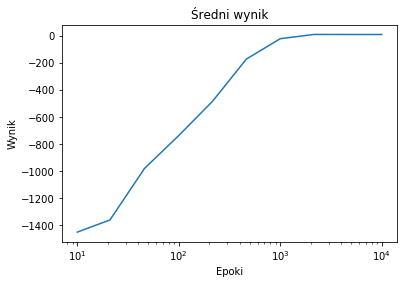

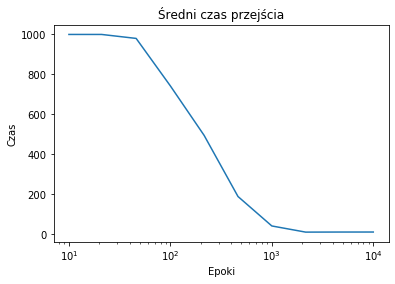

In [19]:
plt.plot(epoch_values, results["score"])
plt.title("Średni wynik")
plt.xscale("log")
plt.xlabel("Epoki")
plt.ylabel("Wynik")
plt.show()

plt.plot(epoch_values, results["time"])
plt.title("Średni czas przejścia")
plt.xscale("log")

plt.xlabel("Epoki")
plt.ylabel("Czas")
plt.show()


Zgodnie z oczekiwaniami, wraz z kolejnymi epokami wzrasta wypłata dla agenta. Wraz z tym, spada czas przejścia zadania (wyrażony w liczbie wykonanych akcji). Na drugim wykresie widać, że w początkowej fazie uczenia agent radzi sobie dość słabo. Średni czas przejścia jest stale równy 1000 - jest to górny limit. Oznacza to, że agent zazwyczaj nie potrafił dojść do stanu terminalnego. Dopiero w okolicach e=10^2, średni czas przejścia zaczął mocno spadać. Na koniec, ustalił się na niskiej wartości - prawdopodobnie bliskiej optymalnie małemu czasowi przejścia.

Wynik z kolei ograniczył się na wartości zbliżonej do nagrody za dowiezienie pasażera (trochę pomniejszonej, ponieważ za akcje nieterminalne nagroda jest pomniejszana).

W następnym eksperymencie sprawdzam, jak wyniki podobnego eksperymentu będą zależeć od parametru ϵ funkcji wyboru akcji.

In [24]:
results_strategy = {}
results_strategy["score"] = []
results_strategy["time"] = []
e_values = np.linspace(0, 1, 10)
for e in e_values:
    Q = q_learning(env, 1000, 0.9, 0.9, 5000, e_greedy_strategy(e))
    result = test_strategy(env, Q, 100, 1000)
    results_strategy["score"].append(result["score"])
    results_strategy["time"].append(result["time"])

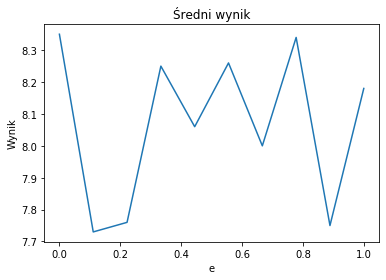

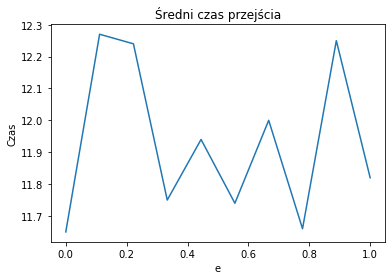

In [25]:
plt.plot(e_values, results_strategy["score"])
plt.title("Średni wynik")
plt.xlabel("e")
plt.ylabel("Wynik")
plt.show()

plt.plot(e_values, results_strategy["time"])
plt.title("Średni czas przejścia")
plt.xlabel("e")
plt.ylabel("Czas")
plt.show()
